In [14]:
import pandas as pd

# Load the datasets
test_df = pd.read_csv('/Users/virgiliaantonucci/Documents/Flatiron/phase_5/data/emotion-labels-test.csv')
train_df = pd.read_csv('/Users/virgiliaantonucci/Documents/Flatiron/phase_5/data/emotion-labels-train.csv')
val_df = pd.read_csv('/Users/virgiliaantonucci/Documents/Flatiron/phase_5/data/emotion-labels-val.csv')

# Check the first few rows of each dataset to understand their structure
test_head = test_df.head()
train_head = train_df.head()
val_head = val_df.head()

(test_head, train_head, val_head)


(                                                text label
 0  You must be knowing #blithe means (adj.)  Happ...   joy
 1  Old saying 'A #smile shared is one gained for ...   joy
 2  Bridget Jones' Baby was bloody hilarious 😅 #Br...   joy
 3  @Elaminova sparkling water makes your life spa...   joy
 4  I'm tired of everybody telling me to chill out...   joy,
                                                 text label
 0  Just got back from seeing @GaryDelaney in Burs...   joy
 1  Oh dear an evening of absolute hilarity I don'...   joy
 2  Been waiting all week for this game ❤️❤️❤️ #ch...   joy
 3  @gardiner_love : Thank you so much, Gloria! Yo...   joy
 4  I feel so blessed to work with the family that...   joy,
                                                 text label
 0  @theclobra lol I thought maybe, couldn't decid...   joy
 1  Nawaz Sharif is getting more funnier than @kap...   joy
 2  Nawaz Sharif is getting more funnier than @kap...   joy
 3  @tomderivan73 😁...I'll just people

In [15]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Initialize stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text, remove_hashtags=False):
    # Convert to lowercase
    text = text.lower()
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove hashtags (if required)
    if remove_hashtags:
        text = re.sub(r'#\w+', '', text)
    # Tokenize
    tokenized_text = word_tokenize(text)
    # Remove stop words and punctuations
    tokenized_text = [word for word in tokenized_text if word.isalpha() and word not in stop_words]
    # Stemming
    stemmed_text = [stemmer.stem(word) for word in tokenized_text]
    # Join back into a string
    text = ' '.join(stemmed_text)
    return text

# Apply cleaning function to the train set for both versions: with and without hashtags
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
train_df['cleaned_text_no_hashtags'] = train_df['text'].apply(lambda x: clean_text(x, remove_hashtags=True))

train_df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/virgiliaantonucci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/virgiliaantonucci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,cleaned_text,cleaned_text_no_hashtags
0,Just got back from seeing @GaryDelaney in Burs...,joy,got back see burslem amaz face still hurt laug...,got back see burslem amaz face still hurt laug...
1,Oh dear an evening of absolute hilarity I don'...,joy,oh dear even absolut hilar think laugh much lo...,oh dear even absolut hilar think laugh much lo...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,wait week game cheer friday,wait week game
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,thank much gloria sweet thought made day joy love,thank much gloria sweet thought made day joy love
4,I feel so blessed to work with the family that...,joy,feel bless work famili nanni noth love amp app...,feel bless work famili nanni noth love amp app...


In [16]:
# Apply the cleaning function to the validation and test sets
val_df['cleaned_text'] = val_df['text'].apply(clean_text)
val_df['cleaned_text_no_hashtags'] = val_df['text'].apply(lambda x: clean_text(x, remove_hashtags=True))

test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_df['cleaned_text_no_hashtags'] = test_df['text'].apply(lambda x: clean_text(x, remove_hashtags=True))

# Display the heads of all dataframes to ensure cleaning was applied correctly
(train_df.head(), val_df.head(), test_df.head())


(                                                text label  \
 0  Just got back from seeing @GaryDelaney in Burs...   joy   
 1  Oh dear an evening of absolute hilarity I don'...   joy   
 2  Been waiting all week for this game ❤️❤️❤️ #ch...   joy   
 3  @gardiner_love : Thank you so much, Gloria! Yo...   joy   
 4  I feel so blessed to work with the family that...   joy   
 
                                         cleaned_text  \
 0  got back see burslem amaz face still hurt laug...   
 1  oh dear even absolut hilar think laugh much lo...   
 2                        wait week game cheer friday   
 3  thank much gloria sweet thought made day joy love   
 4  feel bless work famili nanni noth love amp app...   
 
                             cleaned_text_no_hashtags  
 0  got back see burslem amaz face still hurt laug...  
 1  oh dear even absolut hilar think laugh much lo...  
 2                                     wait week game  
 3  thank much gloria sweet thought made day joy lov

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer with the specified thresholds
vectorizer_cleaned = CountVectorizer(max_df=0.5, min_df=2)

# Vectorize the 'cleaned_text' column of the train, validation, and test sets
X_train_cleaned = vectorizer_cleaned.fit_transform(train_df['cleaned_text'])
X_val_cleaned = vectorizer_cleaned.transform(val_df['cleaned_text'])
X_test_cleaned = vectorizer_cleaned.transform(test_df['cleaned_text'])

# Getting feature names (words) from the vectorizer
feature_names_cleaned = vectorizer_cleaned.get_feature_names_out()

# Display some of the feature names to ensure vectorization was successful
feature_names_cleaned[:10]


array(['aaron', 'aateam', 'ab', 'aberdeen', 'abil', 'abl', 'abort',
       'absolut', 'absurd', 'abt'], dtype=object)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer with the specified thresholds
vectorizer_no_hashtags = CountVectorizer(max_df=0.5, min_df=2)

# Vectorize the 'cleaned_text_no_hashtags' column of the train, validation, and test sets
X_train_no_hashtags = vectorizer_no_hashtags.fit_transform(train_df['cleaned_text_no_hashtags'])
X_val_no_hashtags = vectorizer_no_hashtags.transform(val_df['cleaned_text_no_hashtags'])
X_test_no_hashtags = vectorizer_no_hashtags.transform(test_df['cleaned_text_no_hashtags'])

# Getting feature names (words) from the vectorizer
feature_names_no_hashtags = vectorizer_no_hashtags.get_feature_names_out()

# Display some of the feature names to ensure vectorization was successful
feature_names_no_hashtags[:10]


array(['aaron', 'ab', 'aberdeen', 'abil', 'abl', 'absolut', 'absurd',
       'abt', 'abus', 'abysm'], dtype=object)

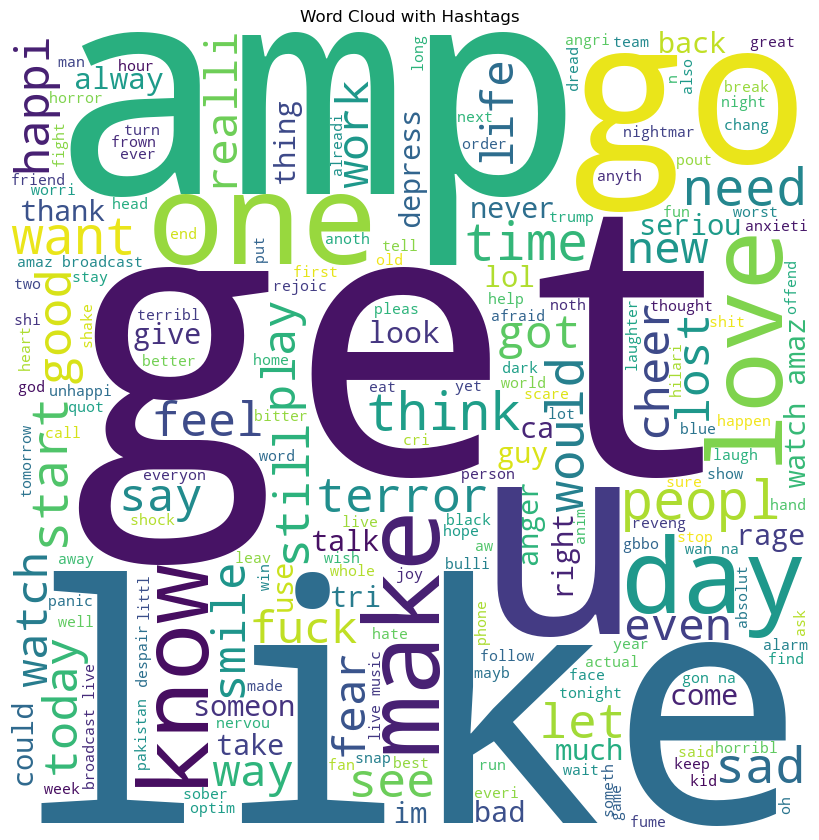

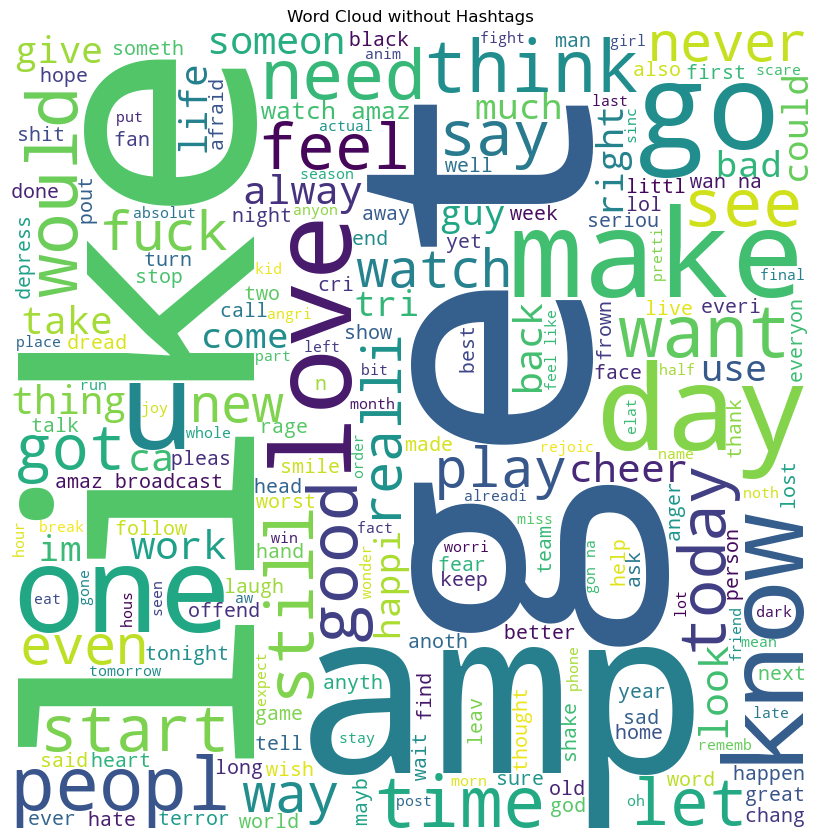

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds
# For cleaned text with hashtags
wordcloud_with_hashtags = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(' '.join(train_df['cleaned_text']))

# For cleaned text without hashtags
wordcloud_no_hashtags = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(' '.join(train_df['cleaned_text_no_hashtags']))

# Plot the word cloud for cleaned text with hashtags
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_with_hashtags) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud with Hashtags")
plt.show()

# Plot the word cloud for cleaned text without hashtags
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_no_hashtags) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud without Hashtags")
plt.show()